# トロッター分解を用いた量子シミュレーション

この記事では量子系のシミュレーション、特に1次元の横磁場イジングモデルの時間発展をシミュレートしている。

## トロッター分解とは

トロッター分解とは、指数関数を以下のように細分化する手法である。
$$e^{h(A+B)} \simeq (e^{hA/n}* e^{hB/n})^{n} + O(\frac{h^2}{n})[1]$$

## なぜ量子シミュレーションにトロッター分解が必要なのか

一般的に量子系の状態の時間発展はシュレーディンガー方程式$ih\frac{\partial}{\partial t}|\psi(t)\rangle = \hat{H}|\psi(t)\rangle$に従う。また、初期状態を$|\psi(0)\rangle$とすると、時間tが経った時の状態を$|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$で表されるが、$e^{-iHt}$を行列にすると大変大きくなる。

よって、量子回路上に、巨大な行列$e^{-iHt}$の代わりに、トロッター分解で得られた多量の量子ゲートを掛けることで、量子コンピュータに乗せたときに計算がより簡単になる。

例えば、$H = \sum_{i=1}^{4} Z_i Z_{i+1}$ので表される行列$H$は16x16の行列であるが、これは4qubitゲートなので、直接量子回路上で実行するのは困難である。

その代わりに、トロッター分解を用いて、２つのZゲートを隣り合う量子ビットのペアにそれぞれ適用したら　(2qubitゲートを5個適用して同じ計算をしたら)　量子コンピュータ上での計算が楽になる。

## イジングモデルとは

物質が磁場に反応する性質を磁性といい、電子が1個あるいは電子の自転運動の向き(スピン)が同じ電子が複数個存在すると磁性を持つと言われている。[2]イジングモデルとは、そんな物質中の隣り合う電子のスピンの相互作用を表したモデルで、以下の数式で表される。

$H = \sum_{i=1}^{n} Z_i Z_{i+1}$ (nは電子の数、$Z \in \{-1,1\}$、 $Z=1$の時スピン上向き、$Z=-1$の時スピン下向き) [3]

各電子ペアのスピンの相互作用をハミルトニアンに見立てると、Zの値が同じであれば　(隣り合うスピンの値が同じであれば)　
エネルギーが低くなる事が分かる。

この時$e^{-iHt} = e^{-i\sum_{i=1}^{n} Z_i Z_{i+1} t} = (e^{-i(Z_1 Z_2 + Z_2 Z_3 + Z_3 Z_4 + Z_4 Z_5 + Z_5 Z_0 )t/n})^{n}$で表せ、$e^{-i \theta Z_i Z_(i+1)}$ は $e^{-i \theta Z_i Z_(i+1)}　= CNOT_{i,i+1}RX(\theta)CNOT_{i,i+1}$の量子ゲートに分解できる。

今回は全磁化　($\langle\psi|\sum_{i=1}^{n} Z_i|\psi\rangle$で記述される、磁性の程度を表す物理量 [4])　の変化に着目する。まずはこのモデルの時間発展を見ていこう。

In [1]:
#必要なライブラリをインポート
from qulacs import QuantumState,QuantumCircuit
from qulacs.gate import X,Z,RX,RY,RZ,CNOT,merge,DenseMatrix,add
from qulacs.state import inner_product
from matplotlib import rc
from scipy.linalg import expm
import matplotlib.pyplot as plt
import numpy as np

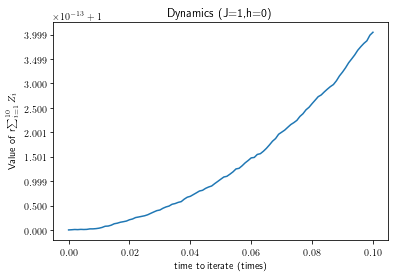

In [24]:
#今回は電子6個の系を想定します。
nqubits = 6
state = QuantumState(nqubits)
state.set_zero_state()

circuit = QuantumCircuit(nqubits)

#トロッター分解の1回分を量子ゲートに変換
def trotter_decomposition(state,circuit,delta,h):
    # implement e^(-i*delta*H)
    for i in range(nqubits):
        circuit.add_CNOT_gate(i,(i+1)%(nqubits))
        circuit.add_RZ_gate((i+1)%10,2*delta)
        circuit.add_CNOT_gate(i,(i+1)%(nqubits))
        circuit.add_RX_gate(i,2*delta*h)
       
    circuit.update_quantum_state(state)

#トロッター分解
def time_evolution(state,circuit,t,n,h):
    x = [i*t/n for i in range(n+1)]#時間
    y = []#時間毎の全磁化の値
    
    #t=0の時の全磁化を計算
    state_buf = QuantumState(nqubits)
    state_buf.load(state)
    for j in range(nqubits):
        zgate = Z(j)
        zgate.update_quantum_state(state_buf)
        
    #計算結果をyに追加
    y.append(inner_product(state,state_buf).real)
    
    #t=0以降の全磁化を計算
    for i in range(n):
        trotter_decomposition(state,circuit,t/n,h)
        state_buf = QuantumState(nqubits)
        state_buf.load(state)
        for j in range(nqubits):
            zgate = Z(j)
            zgate.update_quantum_state(state_buf)
        y.append(inner_product(state,state_buf).real)
    
    #グラフのラベルにTexを使えるようにする
    rc('text', usetex=True)
    
    #グラフの描画
    plt.xlabel("time to iterate (times)")
    plt.ylabel("Value of " + "r$\sum_{i=1}^{10} Z_i$")
    plt.title("Dynamics (J=1,h=0)")
    plt.plot(x,y)
    plt.show()
    
if __name__ == "__main__":
    time_evolution(state,circuit,0.1,100,0)

このグラフを見るときに、まず縦軸のスケールに注意してほしい。ここから、単に電子の相互作用のみを考えると全磁化の値は殆ど変わらないと言える。この原因として、外部からの磁場の影響がないのでスピンの向きが揃っていることが考えられる。次はX軸方向に磁場を加えたイジングモデルの時間発展を見てみよう。

電子のスピンは3次元(X軸、Y軸、Z軸、通常のスピンの変化はZ軸上の変化)で、X軸方向の磁場は一般的に横磁場と呼ばれる。今回実装する1次元の横磁場イジングモデルは以下のように表される。

$$H = \sum_{i=1}^{6} Z_i Z_{i+1} + h\sum_{i=1}^{6} X_i  \text{(hは横磁場の強さを表す係数)}$$ 

では実際にこのモデルでの全磁化の動きを見てみよう。

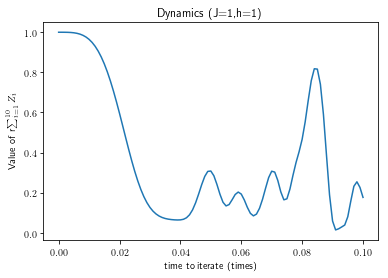

In [65]:
##今回も電子6個の系を想定します。
nqubits = 6
state = QuantumState(nqubits)
state.set_zero_state()

circuit = QuantumCircuit(nqubits)

#トロッター分解の1回分を量子ゲートに変換
def trotter_decomposition(state,circuit,delta,h):
    # implement e^(-i*delta*H)
    for i in range(nqubits):
        circuit.add_CNOT_gate(i,(i+1)%(nqubits))
        circuit.add_RZ_gate((i+1)%10,2*delta)
        circuit.add_CNOT_gate(i,(i+1)%(nqubits))
        circuit.add_RX_gate(i,2*delta*h)
       
    circuit.update_quantum_state(state)

#トロッター分解
def time_evolution(state,circuit,t,n,h):
    x = [i*t/n for i in range(n+1)]#時間
    y = []#時間毎の全磁化の値
    
    #t=0の時の全磁化を計算
    state_buf = QuantumState(nqubits)
    state_buf.load(state)
    for j in range(nqubits):
        zgate = Z(j)
        zgate.update_quantum_state(state_buf)
    #計算結果をyに追加
    y.append(inner_product(state,state_buf).real)
    
    #t=0以降の全磁化を計算
    for i in range(n):
        trotter_decomposition(state,circuit,t/n,h)
        state_buf = QuantumState(nqubits)
        state_buf.load(state)
        for j in range(nqubits):
            zgate = Z(j)
            zgate.update_quantum_state(state_buf)
        y.append(inner_product(state,state_buf).real)
        
    #グラフのラベルにTexを使えるようにする   
    rc('text', usetex=True)
    
    #グラフの描画
    plt.xlabel("time to iterate (times)")
    plt.ylabel("Value of " + "r$\sum_{i=1}^{10} Z_i$")
    plt.title("Dynamics (J=1,h=1)")
    plt.plot(x,y)
    plt.show()

if __name__ == "__main__":
    time_evolution(state,circuit,0.1,100,1)

$h=0$の場合全磁化の値がほぼ1だったのに対し、$h=1$の場合は全磁化の値がその後0近くまで下がっている点で大きく違う。

これは横磁場の影響で、電子のスピンが乱れることで、スピンの向きが乱雑になり、全磁化の値が0近くまで落ち込んでいると考えられる。ちなみに、横磁場をさらに強くしたモデルのダイナミクスは以下のようになる。

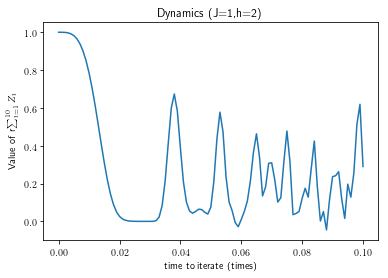

In [4]:
#h=2
nqubits = 6
state = QuantumState(nqubits)
state.set_zero_state()

circuit = QuantumCircuit(nqubits)

def trotter_decomposition(state,circuit,delta,h):
    # implement e^(-i*delta*H)
    for i in range(nqubits):
        circuit.add_CNOT_gate(i,(i+1)%(nqubits))
        circuit.add_RZ_gate((i+1)%10,2*delta)
        circuit.add_CNOT_gate(i,(i+1)%(nqubits))
        circuit.add_RX_gate(i,2*delta*h)
       
    circuit.update_quantum_state(state)

def time_evolution(state,circuit,t,n,h):
    x = [i*t/n for i in range(n+1)]
    y = []
    
    ## t=0
    state_buf = QuantumState(nqubits)
    state_buf.load(state)
    for j in range(nqubits):
        zgate = Z(j)
        zgate.update_quantum_state(state_buf)
    y.append(inner_product(state,state_buf).real)
    
    for i in range(n):
        trotter_decomposition(state,circuit,t/n,h)
        state_buf = QuantumState(nqubits)
        state_buf.load(state)
        for j in range(nqubits):
            zgate = Z(j)
            zgate.update_quantum_state(state_buf)
        y.append(inner_product(state,state_buf).real)
        
    rc('text', usetex=True)

    plt.xlabel("time to iterate (times)")
    plt.ylabel("Value of " + "r$\sum_{i=1}^{10} Z_i$")
    plt.title("Dynamics (J=1,h=2)")
    plt.plot(x,y)
    plt.show()

if __name__ == "__main__":
    time_evolution(state,circuit,0.1,100,2)

この場合は$h=1$の場合に比べて全磁化の値が0近くになるのが早く、また落ち込んだ後の動きが激しいことがよく分かる。

## 厳密解との比較

上のトロッター分解がどれほどの精度のなのか、$e^{-iHt}$を直接計算して厳密な解を求めてトロッター分解と比較する。

$H$の固有値の対角ベクトルを$D$、また固有ベクトルを$P$とすると、$H = P D P^{T}$、$e^{-iHt} = Pe^{-iDt}P^{T}$で表される。

ここでは$h=1$を仮定する。

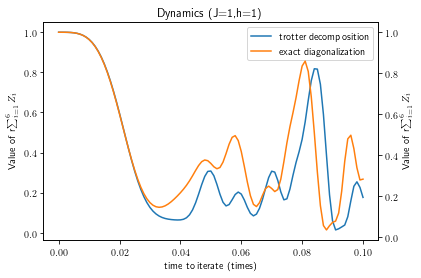

In [39]:
nqubits = 6

state_trotter = QuantumState(nqubits)
state_trotter.set_zero_state()
circuit_trotter = QuantumCircuit(nqubits)

state_exact = QuantumState(nqubits)
state_exact.set_zero_state()
circuit_exact = QuantumCircuit(nqubits)

#トロッター分解の1回分を量子ゲートに変換
def trotter_decomposition(state,circuit,delta,h):
    # implement e^(-i*delta*H)
    for i in range(nqubits):
        circuit.add_CNOT_gate(i,(i+1)%(nqubits))
        circuit.add_RZ_gate((i+1)%10,2*delta)
        circuit.add_CNOT_gate(i,(i+1)%(nqubits))
        circuit.add_RX_gate(i,2*delta*h)
       
    circuit.update_quantum_state(state)

#ハミルトニアンの行列、固有値、固有ベクトルを取得
def get_hamiltonian(h):
    zz = DenseMatrix([0,1],[[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]]) ## 0~1間の相互作用
    x = DenseMatrix(0,[[0,h],[h,0]]) ## 0サイトへの磁場
    
    for i in range(1, nqubits): ## 1以降でループする
        zz = add(zz,DenseMatrix([i,(i+1)%nqubits],[[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]]))
        x = add(x,DenseMatrix(i,[[0,h],[h,0]]))       
    gates = add(zz, x) #量子ゲート
    
    matrix = gates.get_matrix() #量子ゲートの行列の取得
    eigenvalue,P = np.linalg.eigh(np.array(matrix)) #取得した行列の固有値、固有ベクトルを取得
    
    return matrix,eigenvalue,P

def diagonalization(h,delta):
    eigenvalues = np.exp(-1.0j*get_hamiltonian(h)[1]*delta)
    D = np.diag(eigenvalues)　#固有値の対角ベクトルを作成
    H_pre = np.dot(get_hamiltonian(h)[2],D) 
    H = np.dot(H_pre,get_hamiltonian(h)[2].T) #固有値の対角ベクトルからハミルトニアンの行列を計算
    
    return H

#ハミルトニアンの行列を量子回路に適用
def put_circuit(state,circuit,delta,h):
    circuit.add_dense_matrix_gate([i for i in range(nqubits)], diagonalization(h,delta))
    circuit.update_quantum_state(state)


#トロッター分解と厳密対角化の比較
def time_evolution_compare(state1,state2,circuit1,circuit2,t,n,h):
    x_trotter = [i*t/n for i in range(n+1)]#時間
    y_trotter = []#時間毎の全磁化の値
    
    #t=0の時の全磁化を計算
    state_buf = QuantumState(nqubits)
    state_buf.load(state1)
    for j in range(nqubits):
        zgate = Z(j)
        zgate.update_quantum_state(state_buf)
    #計算結果をyに追加
    y_trotter.append(inner_product(state1,state_buf).real)
    
    #t=0以降の全磁化を計算
    for i in range(n):
        trotter_decomposition(state1,circuit1,t/n,h)
        state_buf = QuantumState(nqubits)
        state_buf.load(state1)
        for j in range(nqubits):
            zgate = Z(j)
            zgate.update_quantum_state(state_buf)
        y_trotter.append(inner_product(state1,state_buf).real)

    x_exact = [i*t/n for i in range(n+1)]
    y_exact = []
    
    ## t=0
    state_buf = QuantumState(nqubits)
    state_buf.load(state2)
    for j in range(nqubits):
        zgate = Z(j)
        zgate.update_quantum_state(state_buf)
    y_exact.append(inner_product(state2,state_buf).real)
    
    for i in range(n):
        put_circuit(state2,circuit2,t/n,h)
        state_buf2 = QuantumState(nqubits)
        state_buf2.load(state2)
        for j in range(nqubits):
            zgate = Z(j)
            zgate.update_quantum_state(state_buf2)
        y_exact.append(inner_product(state2,state_buf2).real)
        
    rc('text', usetex=True)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ln1=ax1.plot(x_trotter, y_trotter,'C0',label="trotter decomposition")

    ax2 = ax1.twinx()
    ln2=ax2.plot(x_exact,y_exact,'C1',label="exact diagonalization")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper right')

    ax1.set_xlabel('time to iterate (times)')
    ax1.set_ylabel("Value of " + "r$\sum_{i=1}^{6} Z_i$")
    ax1.grid(False)
    ax2.set_ylabel("Value of " + "r$\sum_{i=1}^{6} Z_i$")
    
    plt.title("Dynamics (J=1,h=1)")
    
if __name__ == "__main__":
    time_evolution_compare(state_trotter,state_exact,circuit_trotter,circuit_exact,0.1,100,1)

よって、上の結果を見れば分かるように、トロッター分解はある程度の時間(0.025秒位)までは厳密解と一致している事が分かる。

それ以外はトロッター分解の誤差が蓄積し、でたらめな結果になっている。

参考文献

[1]「リー・トロッター積公式 - Wikipedia」https://ja.wikipedia.org/wiki/リー・トロッター積公式　(参照日時　04/20/2019)

[2]「磁性　磁性体」http://www.chem.utsunomiya-u.ac.jp/lab/mukizai/jiseitai.pdf (参照日時　04/20/2019)

[3] 田中宗「量子アニーリング法を用いたクラスタ分析」http://www.shutanaka.com/papers_files/ShuTanaka_DEXSMI_10.pdf　
(参照日時　04/20/2019)

[4]　「4.2 磁性体の相転移」http://www.slab.phys.nagoya-u.ac.jp/uwaha/statiii10-4.pdf　(参照日時　04/20/2019)